In [1]:
# Setup plotting
import matplotlib.pyplot as plt
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

In [2]:
# import libraries
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# Load the data
hotel = pd.read_csv('data/hotel.csv.zip')

X = hotel.copy()
y = X.pop('is_canceled')

In [4]:
# Feature engineering
X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )

features_num = [ # todo: can we do not fix this list?
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [ # todo: can we do not fix this list?
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

In [5]:
# Split the data

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

In [6]:
# Preprocess the data 
X_train = preprocessor.fit_transform(X_train) # fit_transform on training data
X_valid = preprocessor.transform(X_valid) # only transform on validation data

input_shape = [X_train.shape[1]] # number of features

In [7]:
# Define the model
model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

In [8]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

<Axes: title={'center': 'Accuracy'}>

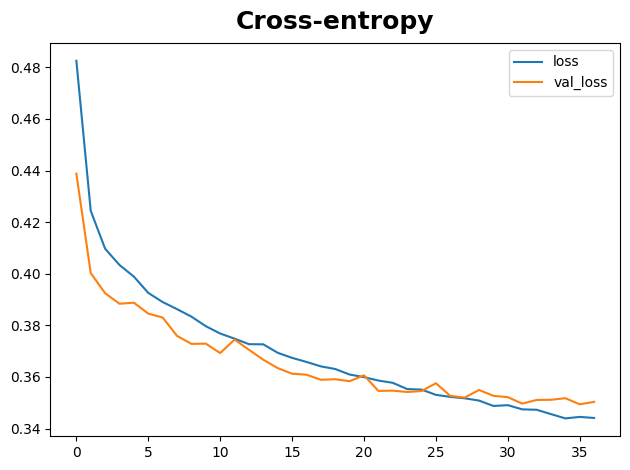

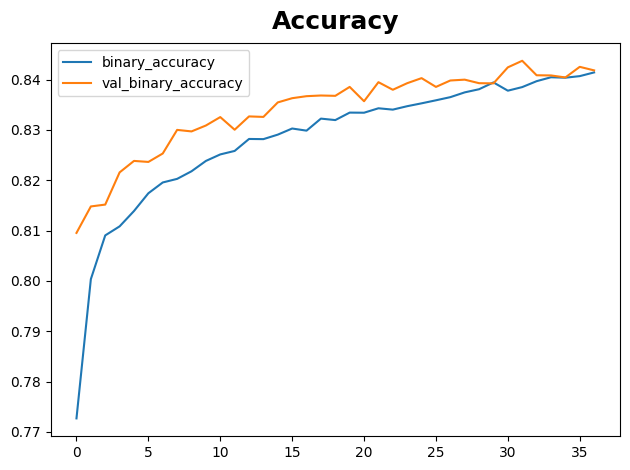

In [9]:
# Provide early stopping callback
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

# Fit the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
        verbose=0, # hide the output because we have so many epochs
)

# Plot the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")